<a href="https://colab.research.google.com/github/gyunini/DeepLearning_From_Scratch/blob/main/%EB%B0%91%EC%8B%9C%EB%94%A5ch05_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오차역전법 구현하기

In [ ]:
# 곱셈계층: z = x*y 일 때 dz/dx = y, dz/dy = x => 즉 dL/dz 와 입력 신호를 바꾼 값을 곱해서 역전파됨

class MulLayer:
    def __init__(self): # 순선파 시의 입력값을 유지하기 위해 사용
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y

        return out

    def backward(self, dout): # dout은 dL/dz (L은 loss를 의미? 상류에서 전해진 미분 값을 의미..)
        dx = dout * self.y  # x와 y를 바꾼다.
        dy = dout * self.x

        return dx, dy

- 곱셈 계층의 계산그래프

In [ ]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dTax:", dtax)

price: 220
dApple: 2.2
dApple_num: 110
dTax: 200


In [ ]:
# 덧셈계층: 덧셈은 그대로.. z = x + y => dz/dx = 1, dz/dy = 1

class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y

        return out

    def backward(self, dout):
        dx = dout * 1 # 그대로 전파
        dy = dout * 1

        return dx, dy

In [ ]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)

price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


## 활성화 함수 계층 구현하기
- Relu 계층 구현

In [ ]:
import numpy as np

class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0) # mask는 True/False로 구성된 넘파이배열
    out = x.copy()
    out[self.mask] = 0 # 0보다 작은 원소 (True)인 것들을 0으로 바꿈

    return out

  def backward(self, dout):
    dout[self.mask] = 0 # 역전파 때는 0보다 크면 그대로 흘리고 0보다 작으면 0으로 됨. -> 0보다 작은 원소 (True)인 것들을 0으로 바꿈
    dx = dout

    return dx

In [ ]:
x = np.array([[1.0, -0.5], [-2.0, 3.0]])
print(x)

mask = (x <= 0) # 넘파이 배열과 대소비교를 하면 T/F로 이루어진 배열이 나옴
print(mask)

[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]


- Sigmoid 계층 구현

In [ ]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * self.out * (1.0 - self.out) # y*(1-y) * dL/dY

        return dx

- Affine 계층 : 행렬의 곱을 수행하는 계층

In [ ]:
X = np.random.rand(2) #  입력
W = np.random.rand(2,3) # 가중치
B = np.random.rand(3) # 편향

print(X.shape)
print(W.shape)
print(B.shape)

Y = np.dot(X, W) + B
print(Y)

(2,)
(2, 3)
(3,)
[1.31285162 2.10641624 0.80013504]


- Affine 계층에서의 역전파 계산그래프는 행렬 미분 참고 (배치용)

In [ ]:
X_dot_W = np.array([[0,0,0], [10,10,10]])
B = np.array([1,2,3])
print(X_dot_W)

print(X_dot_W + B) # Broadcasting

[[ 0  0  0]
 [10 10 10]]
[[ 1  2  3]
 [11 12 13]]


In [ ]:
dY = np.array([[1,2,3], [4,5,6]])
print(dY)

dB = np.sum(dY, axis=0)
print(dB)

[[1 2 3]
 [4 5 6]]
[5 7 9]


- 배치용 Affine 계층 구현
- Y = X*B + B (모두 행렬로 이루어짐)

In [ ]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T) # dL/dx = dL/dY * W.T
        self.dW = np.dot(self.x.T, dout) # dL/dy = X.T * dL/dY
        self.db = np.sum(dout, axis=0) # dL/dY의 첫 번째 축(열방향)으로의 합

        return dx

In [ ]:
# 입력 데이터가 텐서(4차원 데이터) 인 경우도 고려
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1) # 이차원으로 reshape
        self.x = x                    # 이차원으로 바뀐것을 저장

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

# Softmax with Loss 계층 구현**

In [ ]:
def softmax(x):
  if x.ndim == 2:
    x = x.T
    x = x - np.max(x, axis=0)
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y.T

  x = x - np.max(x) # 오버플로 대책
  return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
  if t.size == y.size:
    t = t.argmax(axis=1)

  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 값 복원
        it.iternext()

    return grad

- SoftmaxWithLoss 계층 구현하기 -> 계산그래프 복잠하지만 결론적으로는 y - t가 역전파

In [ ]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else: # t가 원-핫벡터가 아니라 클래스 인덱스로 레이블링 될 때
            dx = self.y.copy() # softmax의 출력을 복사
            dx[np.arange(batch_size), self.t] -= 1 # 올바른 클래스에 해당하는 예측 클래스 확률('self.y')에서 1을 빼서 역전파 중에 올바른 클래스가 더 높은 확률을 갖고 다른 클래스가 더 낮은 확률을 갖도록 합니다.
            dx = dx / batch_size

        return dx

## 오차역전법을 활용한 신경망 구현

In [ ]:
import numpy as np
from collections import OrderedDict


# 두개의 레이어
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size) # 크기에 맞게 정규화된 행렬 생성
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성: Affine이후에 렐루 함수로 활성화 함수 (계층 1) => 이후 Affine 이후 softmax, cross entropy loss 계산 (마지막에서는 활성화 함수 안함????)
        self.layers = OrderedDict() # 순서를 유지하기 위해서 OrderedDict사용
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss() # 마지막 계층

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x) # 각 layer class에 정의된 forward메소드 호출(SoftmaxWithLoss제외)

        return x # 최종 값은 Affine2에서 나온 행렬 곱의 결과

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t): # y값을 SoftmaxWithLoss계층에 통과시켜서 loss를 계산
        y = self.predict(x) # y => Affine2에서 나온 행렬 곱의 결과
        return self.lastLayer.forward(y, t)  # y값을 SoftmaxWithLoss계층에 통과시켜서 loss를 계산

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1) # 열방향으로 진행하면서 최댓값의 인덱스 찾음 -> 즉 각 행에서 최댓값의 인덱스를 찾는것
        if t.ndim != 1 :  # t가 원핫벡터일 때
          t = np.argmax(t, axis=1) # 정답 레이블만 추출

        accuracy = np.sum(y == t) / float(x.shape[0]) # 정답률 계산
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse() # reversed()와 다르게 리스트 자체를 뒤집어버림
        for layer in layers:
            dout = layer.backward(dout) # 왜 근데 역전파할때 dx만 리턴해서 전파하지??????????????

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys, os
sys.path.append('/content/drive/MyDrive/Colab Notebooks/2023_AI')
sys.path.extend("./")
from mnist import load_mnist

### 오차역전법으로 구한 기울기 검증하기(numerical gradient와 비교해서 차이 없는지)

In [ ]:
import numpy as np

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3] # 배치 생성
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 절대 오차의 평균을 구한다.
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:7.617099527048775e-07
b1:5.00661682587191e-06
W2:4.559652330515436e-09
b2:1.4038150851908292e-07


- 결과를 보면 거의 차이가 없음

### 오차역전법 **학습시키기**

In [ ]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10) # 계층 클래스 생성

iters_num = 10000
train_size = x_train.shape[0] # 60000
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1) # 배치 사이즈가 더 클 경우 1보다 작을 수 있으니 이때는 1을 선택해라는 의미..

for i in range(iters_num): # 만번 반복
    batch_mask = np.random.choice(train_size, batch_size) # train_size내에서 batch_size개수만큼 랜덤하게 추출
    x_batch = x_train[batch_mask] # 배치 만들기
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)

    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key] # => SGD 방식...

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.1104 0.1121
0.9032666666666667 0.907
0.9201833333333334 0.9235
0.9371 0.935
0.9462833333333334 0.9453
0.9535333333333333 0.951
0.9589166666666666 0.9547
0.9612833333333334 0.9563
0.9658166666666667 0.9615
0.9681166666666666 0.9634
0.9699333333333333 0.9646
0.97225 0.9683
0.9736833333333333 0.9678
0.9764833333333334 0.9692
0.9775666666666667 0.9697
0.9797 0.9711
0.9799666666666667 0.9708


# Ch06 - 학습 관련 기술들

# 1. 매개변수 갱신 기법들 - SGD, Momentum, AdaGrad, Adam

In [ ]:
class SGD:
  def __init__(self, lr = 0.01):
    self.lr = lr

  def update(self, params, grads):
    for key in params.keys():
      params[key] -= self.lr * grads[key]

'''
optimizer = SGD()
optimizer.update(params, grads) 이런식으로 수행
'''

'\noptimizer = SGD()\noptimizer.update(params, grads) 이런식으로 수행\n'

In [ ]:
class Momentum:
  def __init__(self, lr=0.01, momentum=0.9):
    self.lr = lr
    self.momentum = momentum
    self.v = None

  def update(self, params, grads):
    if self.v is None:
      self.v = {}
      for key, val in params.items():
        self.v[key] = np.zeros_like(val)

    for key in params.keys():
      self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
      params[key] += self.v[key]

- learning rate decay(학습률 감소)

In [ ]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val) # 초기화

        for key in params.keys():
            self.h[key] += grads[key] * grads[key] # 기울기 제곱, h라는 새로운 변수
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 작은 값 더해서 0으로 나누는 것 방지

In [ ]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

# 2. 가중치를 어떻게 초기화 할거냐 - Xavier, He

###MultiLayerNet에 대한 설명

- 여러 층 계산 가능
- 가중치 초기화를 He, Xavier로 구현
- weight decay(가중치 감소)를 구현 - L2 norm, L1 norm..



In [ ]:
class MultiLayerNet:
    """완전연결 다층 신경망

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    ex) networks = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100], output_size=10)
    """
    def __init__(self, input_size, hidden_size_list, output_size, activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list) # hidden list의 길이
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std) # 가중치를 계층에 따라서 쭉 초기화해줌 relu -> He initialization으로 초기화

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1): # hidden layer 개수만큼 계층 생성: self.layers
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]() # Relu(), Sigmoid()

        idx = self.hidden_layer_num + 1 # 마지막에 Affine 하나 더 생성
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss() # 맨 마지막 계층

    def __init_weight(self, weight_init_std): # relu -> He
        """가중치 초기화

        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size] # [784, 100, 100, 100, 100, 10] -> all_size_list
        for idx in range(1, len(all_size_list)) # 리스트를 돌면서 각 계층의 노드 수(idx)를 이용
            scale = weight_init_std # relu
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값 He 초기화는 sqrt(2/n)인 정규분포 이용
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            # np.random.randn : 평균 0, 표준편차 1인 (m,n) 행렬 생성 -> 즉 [idx-1]은 인풋 노드 크기, [idx]는 아웃풋 노드 크기임
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])
            # 결과적으로 self.params dictionary를 랜덤하게 초기화 해줌

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x) # layers 를 거쳐 나온 결과값

        weight_decay = 0 # 가중치 감소: L2 norm 이용 ** -> 1/2*람다*W^2를 손실함수에 더함
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay # sorfmaxWithLoss에 weight_decay를 더함

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """기울기를 구한다(수치 미분).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

In [ ]:
def smooth_curve(x):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용

    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]

# MNIST 데이터셋으로 살펴보는 가중치 갱신 방법 비교

===========iteration:0===========
SGD:2.4169074407041276
Momentum:2.3883989106265666
AdaGrad:2.5791766113206904
Adam:2.1831209224046084
===========iteration:100===========
SGD:1.5757302195623228
Momentum:0.5194376411121611
AdaGrad:0.2166059326838304
Adam:0.5251932283698467
===========iteration:200===========
SGD:0.7364713016209915
Momentum:0.2377683690901266
AdaGrad:0.10464544121066671
Adam:0.146876463819839
===========iteration:300===========
SGD:0.6782148966081994
Momentum:0.27298462388134076
AdaGrad:0.09743589380647723
Adam:0.2267560545484345
===========iteration:400===========
SGD:0.3469533686649173
Momentum:0.16745965384011113
AdaGrad:0.08852471681690964
Adam:0.12021144412398126
===========iteration:500===========
SGD:0.430456291136075
Momentum:0.19804769208299947
AdaGrad:0.12480798268575871
Adam:0.1802988638060565
===========iteration:600===========
SGD:0.5035718652365417
Momentum:0.16461240572172267
AdaGrad:0.05032462855741206
Adam:0.13058780980241028
===========iteration:700===

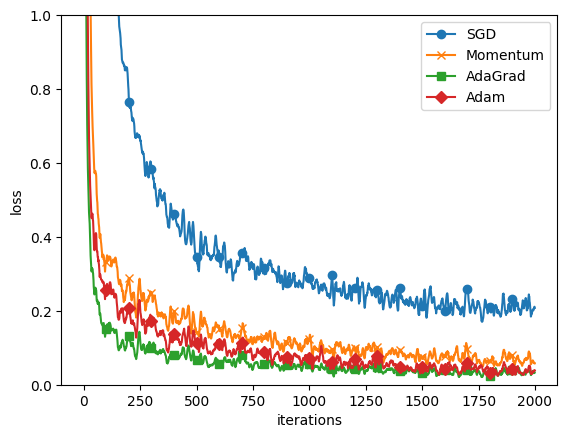

In [ ]:
import matplotlib.pyplot as plt

# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations): # 2000번 반복
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch) # 오차역전법으로 기울기 계산
        optimizers[key].update(networks[key].params, grads) # 가중치 갱신

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0: # 100번마다 수행
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key) # smooth_curve 사용
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

# 가중치 초기값 설정에 따른 비교

- Xavier: 계층이 깊어질 수록 형태가 일그러지지만 확실히 넓게 분포됨
- He: Relu전용 초기화

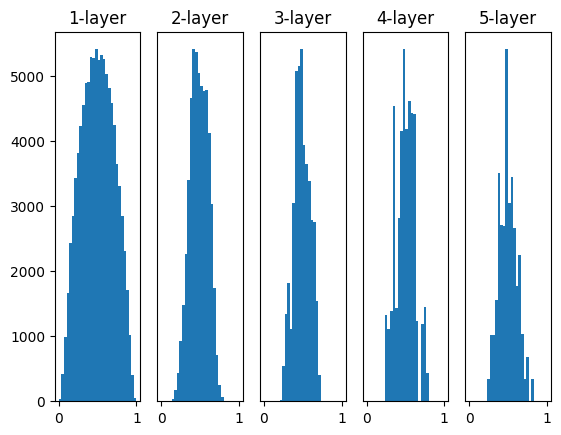

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)

input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1] # 이전 계층을 이용하기 위해서

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    # w = np.random.randn(node_num, node_num) * 1 # 표준편차 0.01
    # w = np.random.randn(node_num, node_num) * 0.01 # 표준편차 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) # Xavier
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) # He -> Relu를 사용할 때..


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

# MNIST 데이터셋으로 살펴보는 가중치 초기값 비교

- He 가 속도가 가장 빠름

===========iteration:0===========
std=0.01:2.3024508621628
Xavier:2.3046863138092553
He:2.3720470953692594
===========iteration:100===========
std=0.01:2.3019263606326064
Xavier:2.2489882735507187
He:1.397692999613389
===========iteration:200===========
std=0.01:2.3033710099303626
Xavier:2.1290040805369017
He:0.8559719035573534
===========iteration:300===========
std=0.01:2.301602676600834
Xavier:1.7884711511746274
He:0.5571802972492916
===========iteration:400===========
std=0.01:2.3005872803202028
Xavier:1.1325680908873808
He:0.4570336889128524
===========iteration:500===========
std=0.01:2.30255075820161
Xavier:0.7768147283961322
He:0.2975907231178751
===========iteration:600===========
std=0.01:2.298491450356229
Xavier:0.6399987807086964
He:0.35953947311866674
===========iteration:700===========
std=0.01:2.302839599448566
Xavier:0.5299151217581295
He:0.31017002488619067
===========iteration:800===========
std=0.01:2.3066182375226196
Xavier:0.5222983890255527
He:0.3147572380751297
=

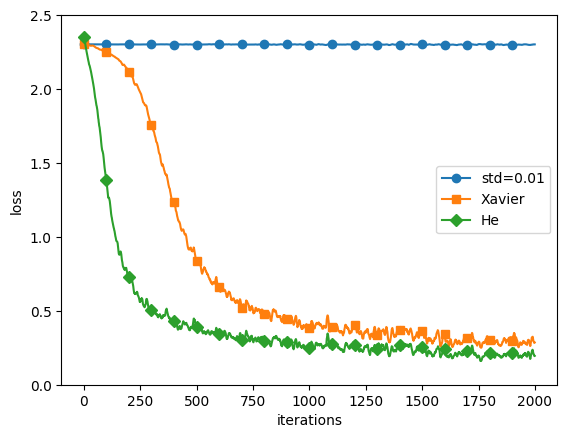

In [ ]:
# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01) # optimizer : 가중치 갱신 방법

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type) # weight_init_types에 있는 val 에 따라서 초기화를 달리 해줌
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size) # 배치 설정
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in weight_init_types.keys(): # grad, loss 계산..
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads) # SGD

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

### 배치정규화와 Dropout 구현 class

In [ ]:
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var

        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)

        return out.reshape(*self.input_shape)

    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)

        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std

            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))

        out = self.gamma * xn + self.beta
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size

        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx

### 완전 연결 다층 신경망(확장판) : 가중치 감소, 드롭아웃, 배치 정규화 구현



In [ ]:
class MultiLayerNetExtend:
    """완전 연결 다층 신경망(확장판)
    가중치 감소, 드롭아웃, 배치 정규화 구현

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    use_dropout : 드롭아웃 사용 여부
    dropout_ration : 드롭아웃 비율
    use_batchNorm : 배치 정규화 사용 여부
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0,
                 use_dropout = False, dropout_ration = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])

            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화

        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=False):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, X, T):
        Y = self.predict(X, train_flg=False)
        Y = np.argmax(Y, axis=1)
        if T.ndim != 1 : T = np.argmax(T, axis=1)

        accuracy = np.sum(Y == T) / float(X.shape[0])
        return accuracy

    def numerical_gradient(self, X, T):
        """기울기를 구한다(수치 미분).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(X, T, train_flg=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads

### 배치 정규화의 효과

============== 1/16 ==============
epoch:0 | 0.092 - 0.078


<ipython-input-74-4bd93e01ab44>:96: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
<ipython-input-74-4bd93e01ab44>:96: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.117 - 0.12
epoch:2 | 0.117 - 0.14
epoch:3 | 0.117 - 0.158
epoch:4 | 0.116 - 0.184
epoch:5 | 0.116 - 0.196
epoch:6 | 0.116 - 0.199
epoch:7 | 0.117 - 0.222
epoch:8 | 0.117 - 0.229
epoch:9 | 0.117 - 0.253
epoch:10 | 0.117 - 0.274
epoch:11 | 0.117 - 0.28
epoch:12 | 0.117 - 0.301
epoch:13 | 0.117 - 0.319
epoch:14 | 0.117 - 0.331
epoch:15 | 0.117 - 0.35
epoch:16 | 0.117 - 0.365
epoch:17 | 0.117 - 0.377
epoch:18 | 0.117 - 0.39


epoch:19 | 0.116 - 0.402
============== 2/16 ==============
epoch:0 | 0.117 - 0.095


<ipython-input-57-b5c2ee6986b6>:4: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:1 | 0.097 - 0.097
epoch:2 | 0.097 - 0.111
epoch:3 | 0.097 - 0.154
epoch:4 | 0.097 - 0.19
epoch:5 | 0.097 - 0.221
epoch:6 | 0.097 - 0.242
epoch:7 | 0.097 - 0.259
epoch:8 | 0.097 - 0.282
epoch:9 | 0.097 - 0.298
epoch:10 | 0.097 - 0.331
epoch:11 | 0.097 - 0.347
epoch:12 | 0.097 - 0.378
epoch:13 | 0.097 - 0.384
epoch:14 | 0.097 - 0.407
epoch:15 | 0.097 - 0.423
epoch:16 | 0.097 - 0.433
epoch:17 | 0.097 - 0.453
epoch:18 | 0.097 - 0.466


epoch:19 | 0.097 - 0.486
============== 3/16 ==============
epoch:0 | 0.093 - 0.102
epoch:1 | 0.235 - 0.102
epoch:2 | 0.368 - 0.123
epoch:3 | 0.468 - 0.173
epoch:4 | 0.56 - 0.205
epoch:5 | 0.598 - 0.236
epoch:6 | 0.661 - 0.279
epoch:7 | 0.703 - 0.297
epoch:8 | 0.748 - 0.334
epoch:9 | 0.772 - 0.367
epoch:10 | 0.805 - 0.388
epoch:11 | 0.824 - 0.405
epoch:12 | 0.836 - 0.44
epoch:13 | 0.864 - 0.475
epoch:14 | 0.87 - 0.499
epoch:15 | 0.883 - 0.523
epoch:16 | 0.891 - 0.554
epoch:17 | 0.906 - 0.574
epoch:18 | 0.912 - 0.594


epoch:19 | 0.925 - 0.614
============== 4/16 ==============
epoch:0 | 0.119 - 0.095
epoch:1 | 0.233 - 0.124
epoch:2 | 0.346 - 0.197
epoch:3 | 0.464 - 0.269
epoch:4 | 0.539 - 0.33
epoch:5 | 0.604 - 0.396
epoch:6 | 0.661 - 0.449
epoch:7 | 0.681 - 0.496
epoch:8 | 0.711 - 0.525
epoch:9 | 0.743 - 0.562
epoch:10 | 0.758 - 0.6
epoch:11 | 0.777 - 0.626
epoch:12 | 0.786 - 0.645
epoch:13 | 0.8 - 0.676
epoch:14 | 0.816 - 0.689
epoch:15 | 0.821 - 0.715
epoch:16 | 0.83 - 0.73
epoch:17 | 0.845 - 0.742
epoch:18 | 0.854 - 0.756
epoch:19 | 0.853 - 0.774


============== 5/16 ==============
epoch:0 | 0.085 - 0.112
epoch:1 | 0.094 - 0.176
epoch:2 | 0.096 - 0.293
epoch:3 | 0.105 - 0.446
epoch:4 | 0.119 - 0.532
epoch:5 | 0.145 - 0.601
epoch:6 | 0.16 - 0.643
epoch:7 | 0.181 - 0.685
epoch:8 | 0.185 - 0.721
epoch:9 | 0.219 - 0.743
epoch:10 | 0.229 - 0.772
epoch:11 | 0.253 - 0.805
epoch:12 | 0.279 - 0.819
epoch:13 | 0.303 - 0.828
epoch:14 | 0.33 - 0.849
epoch:15 | 0.343 - 0.86
epoch:16 | 0.361 - 0.864
epoch:17 | 0.362 - 0.873
epoch:18 | 0.387 - 0.878


epoch:19 | 0.394 - 0.89
============== 6/16 ==============
epoch:0 | 0.102 - 0.107
epoch:1 | 0.155 - 0.189
epoch:2 | 0.116 - 0.374
epoch:3 | 0.116 - 0.541
epoch:4 | 0.117 - 0.646
epoch:5 | 0.116 - 0.699
epoch:6 | 0.124 - 0.748
epoch:7 | 0.117 - 0.783
epoch:8 | 0.116 - 0.812
epoch:9 | 0.116 - 0.827
epoch:10 | 0.116 - 0.852
epoch:11 | 0.116 - 0.867
epoch:12 | 0.116 - 0.88
epoch:13 | 0.116 - 0.892
epoch:14 | 0.116 - 0.9
epoch:15 | 0.116 - 0.918
epoch:16 | 0.117 - 0.925
epoch:17 | 0.116 - 0.933
epoch:18 | 0.116 - 0.933


epoch:19 | 0.116 - 0.944
============== 7/16 ==============
epoch:0 | 0.111 - 0.102
epoch:1 | 0.116 - 0.354
epoch:2 | 0.116 - 0.597
epoch:3 | 0.117 - 0.7
epoch:4 | 0.117 - 0.743
epoch:5 | 0.117 - 0.777
epoch:6 | 0.117 - 0.821
epoch:7 | 0.117 - 0.851
epoch:8 | 0.117 - 0.876
epoch:9 | 0.117 - 0.907
epoch:10 | 0.117 - 0.921
epoch:11 | 0.117 - 0.945
epoch:12 | 0.117 - 0.952
epoch:13 | 0.117 - 0.958
epoch:14 | 0.117 - 0.97
epoch:15 | 0.117 - 0.97
epoch:16 | 0.117 - 0.975
epoch:17 | 0.117 - 0.975
epoch:18 | 0.117 - 0.98


epoch:19 | 0.117 - 0.983
============== 8/16 ==============
epoch:0 | 0.116 - 0.15
epoch:1 | 0.117 - 0.434
epoch:2 | 0.117 - 0.686
epoch:3 | 0.117 - 0.765
epoch:4 | 0.117 - 0.808
epoch:5 | 0.117 - 0.842
epoch:6 | 0.117 - 0.874
epoch:7 | 0.117 - 0.905
epoch:8 | 0.117 - 0.94
epoch:9 | 0.117 - 0.967
epoch:10 | 0.117 - 0.982
epoch:11 | 0.117 - 0.988
epoch:12 | 0.117 - 0.993
epoch:13 | 0.117 - 0.995
epoch:14 | 0.117 - 0.995
epoch:15 | 0.117 - 0.997
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.997
epoch:18 | 0.117 - 1.0


epoch:19 | 0.117 - 1.0
============== 9/16 ==============
epoch:0 | 0.087 - 0.098
epoch:1 | 0.116 - 0.528
epoch:2 | 0.117 - 0.739
epoch:3 | 0.117 - 0.796
epoch:4 | 0.116 - 0.846
epoch:5 | 0.116 - 0.881
epoch:6 | 0.117 - 0.885
epoch:7 | 0.117 - 0.935
epoch:8 | 0.117 - 0.961
epoch:9 | 0.117 - 0.979
epoch:10 | 0.117 - 0.991
epoch:11 | 0.117 - 0.993
epoch:12 | 0.117 - 0.995
epoch:13 | 0.117 - 0.996
epoch:14 | 0.117 - 0.997
epoch:15 | 0.117 - 0.998
epoch:16 | 0.116 - 1.0
epoch:17 | 0.116 - 1.0
epoch:18 | 0.116 - 1.0
epoch:19 | 0.117 - 1.0


============== 10/16 ==============
epoch:0 | 0.105 - 0.121
epoch:1 | 0.116 - 0.545
epoch:2 | 0.116 - 0.69
epoch:3 | 0.116 - 0.812
epoch:4 | 0.116 - 0.845
epoch:5 | 0.116 - 0.845
epoch:6 | 0.116 - 0.89
epoch:7 | 0.117 - 0.894
epoch:8 | 0.117 - 0.899
epoch:9 | 0.116 - 0.906
epoch:10 | 0.116 - 0.939
epoch:11 | 0.116 - 0.982
epoch:12 | 0.116 - 0.991
epoch:13 | 0.116 - 0.996
epoch:14 | 0.116 - 0.997
epoch:15 | 0.116 - 0.996
epoch:16 | 0.116 - 0.998
epoch:17 | 0.116 - 0.998
epoch:18 | 0.116 - 0.997


epoch:19 | 0.116 - 0.997
============== 11/16 ==============
epoch:0 | 0.117 - 0.166
epoch:1 | 0.117 - 0.512
epoch:2 | 0.117 - 0.678
epoch:3 | 0.117 - 0.634
epoch:4 | 0.117 - 0.749
epoch:5 | 0.117 - 0.764
epoch:6 | 0.117 - 0.788
epoch:7 | 0.117 - 0.874
epoch:8 | 0.117 - 0.964
epoch:9 | 0.117 - 0.957
epoch:10 | 0.117 - 0.973
epoch:11 | 0.117 - 0.987
epoch:12 | 0.117 - 0.99
epoch:13 | 0.117 - 0.893
epoch:14 | 0.117 - 0.982
epoch:15 | 0.117 - 0.989
epoch:16 | 0.117 - 0.976
epoch:17 | 0.117 - 0.992
epoch:18 | 0.117 - 0.996
epoch:19 | 0.117 - 0.994


============== 12/16 ==============
epoch:0 | 0.117 - 0.105
epoch:1 | 0.097 - 0.58
epoch:2 | 0.117 - 0.687
epoch:3 | 0.117 - 0.718
epoch:4 | 0.117 - 0.736
epoch:5 | 0.117 - 0.745
epoch:6 | 0.116 - 0.774
epoch:7 | 0.117 - 0.78
epoch:8 | 0.117 - 0.795
epoch:9 | 0.117 - 0.788
epoch:10 | 0.117 - 0.854
epoch:11 | 0.117 - 0.811
epoch:12 | 0.117 - 0.814
epoch:13 | 0.117 - 0.802
epoch:14 | 0.117 - 0.801
epoch:15 | 0.117 - 0.895
epoch:16 | 0.117 - 0.898
epoch:17 | 0.117 - 0.897
epoch:18 | 0.117 - 0.899


epoch:19 | 0.117 - 0.899
============== 13/16 ==============
epoch:0 | 0.093 - 0.13
epoch:1 | 0.1 - 0.485
epoch:2 | 0.117 - 0.544
epoch:3 | 0.117 - 0.573
epoch:4 | 0.117 - 0.607
epoch:5 | 0.117 - 0.648
epoch:6 | 0.116 - 0.645
epoch:7 | 0.117 - 0.677
epoch:8 | 0.116 - 0.659
epoch:9 | 0.116 - 0.689
epoch:10 | 0.116 - 0.694
epoch:11 | 0.116 - 0.675
epoch:12 | 0.116 - 0.697
epoch:13 | 0.117 - 0.682
epoch:14 | 0.117 - 0.7
epoch:15 | 0.117 - 0.709
epoch:16 | 0.117 - 0.71
epoch:17 | 0.117 - 0.711
epoch:18 | 0.117 - 0.705


epoch:19 | 0.117 - 0.707
============== 14/16 ==============
epoch:0 | 0.1 - 0.199
epoch:1 | 0.116 - 0.303
epoch:2 | 0.117 - 0.311
epoch:3 | 0.117 - 0.314
epoch:4 | 0.117 - 0.469
epoch:5 | 0.117 - 0.452
epoch:6 | 0.117 - 0.487
epoch:7 | 0.117 - 0.513
epoch:8 | 0.117 - 0.481
epoch:9 | 0.117 - 0.518
epoch:10 | 0.116 - 0.52
epoch:11 | 0.117 - 0.517
epoch:12 | 0.116 - 0.525
epoch:13 | 0.116 - 0.527
epoch:14 | 0.116 - 0.522
epoch:15 | 0.116 - 0.524
epoch:16 | 0.117 - 0.519
epoch:17 | 0.116 - 0.526
epoch:18 | 0.116 - 0.525


epoch:19 | 0.117 - 0.525
============== 15/16 ==============
epoch:0 | 0.117 - 0.18
epoch:1 | 0.116 - 0.349
epoch:2 | 0.116 - 0.486
epoch:3 | 0.116 - 0.343
epoch:4 | 0.117 - 0.499
epoch:5 | 0.117 - 0.509
epoch:6 | 0.117 - 0.5
epoch:7 | 0.117 - 0.519
epoch:8 | 0.117 - 0.528
epoch:9 | 0.117 - 0.522
epoch:10 | 0.117 - 0.571
epoch:11 | 0.117 - 0.593
epoch:12 | 0.117 - 0.6
epoch:13 | 0.117 - 0.609
epoch:14 | 0.117 - 0.592
epoch:15 | 0.117 - 0.613
epoch:16 | 0.117 - 0.618
epoch:17 | 0.117 - 0.614
epoch:18 | 0.117 - 0.619


epoch:19 | 0.117 - 0.613
============== 16/16 ==============
epoch:0 | 0.093 - 0.093
epoch:1 | 0.116 - 0.302
epoch:2 | 0.116 - 0.345
epoch:3 | 0.116 - 0.363
epoch:4 | 0.117 - 0.402
epoch:5 | 0.117 - 0.403
epoch:6 | 0.117 - 0.419
epoch:7 | 0.117 - 0.411
epoch:8 | 0.117 - 0.418
epoch:9 | 0.117 - 0.422
epoch:10 | 0.117 - 0.419
epoch:11 | 0.117 - 0.426
epoch:12 | 0.117 - 0.428
epoch:13 | 0.117 - 0.428
epoch:14 | 0.117 - 0.43
epoch:15 | 0.117 - 0.43
epoch:16 | 0.117 - 0.431
epoch:17 | 0.117 - 0.432
epoch:18 | 0.117 - 0.43
epoch:19 | 0.117 - 0.43


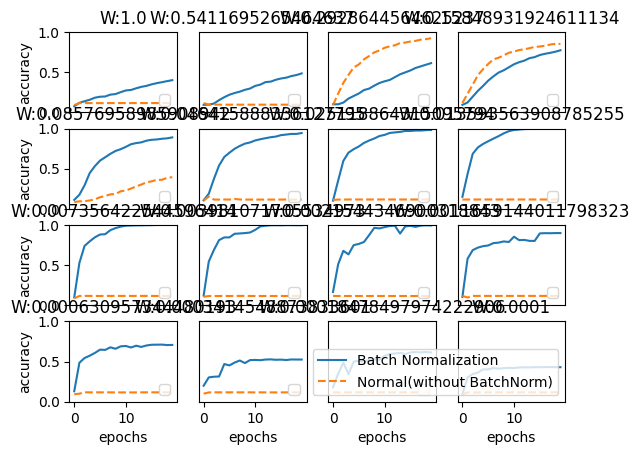

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)

    train_acc_list = []
    bn_train_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)

            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))

            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break

    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)

    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')

plt.show()

# 오버피팅

## 가중치 감소를 사용했을 때 오버피팅 방지 가능

epoch:0, train acc:0.10666666666666667, test acc:0.0909
epoch:1, train acc:0.12333333333333334, test acc:0.1011
epoch:2, train acc:0.12666666666666668, test acc:0.1082
epoch:3, train acc:0.15, test acc:0.1213
epoch:4, train acc:0.17, test acc:0.1321
epoch:5, train acc:0.21, test acc:0.1481
epoch:6, train acc:0.22, test acc:0.1585
epoch:7, train acc:0.25333333333333335, test acc:0.1776
epoch:8, train acc:0.2866666666666667, test acc:0.1902
epoch:9, train acc:0.2966666666666667, test acc:0.1945
epoch:10, train acc:0.31333333333333335, test acc:0.2134
epoch:11, train acc:0.34, test acc:0.2229
epoch:12, train acc:0.35333333333333333, test acc:0.2367
epoch:13, train acc:0.38, test acc:0.2565
epoch:14, train acc:0.4266666666666667, test acc:0.2814
epoch:15, train acc:0.44333333333333336, test acc:0.295
epoch:16, train acc:0.47333333333333333, test acc:0.3128
epoch:17, train acc:0.47333333333333333, test acc:0.3152
epoch:18, train acc:0.45666666666666667, test acc:0.3118
epoch:19, train acc:0

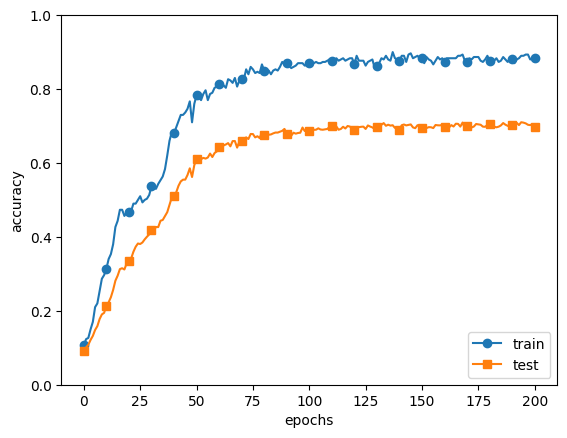

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [ ]:
class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. (http://newsight.tistory.com/224)

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]

In [ ]:
class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [ ]:
class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01},
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)

        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0

        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]

        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)

        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))

        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1

            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]

            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))


### 드롭아웃을 썼을 때 효과

train loss:2.2979052155148083
=== epoch:1, train acc:0.08333333333333333, test acc:0.0958 ===
train loss:2.294538117583961
train loss:2.28483852611656
train loss:2.3012659461007035
=== epoch:2, train acc:0.08333333333333333, test acc:0.0988 ===
train loss:2.3015796775432995
train loss:2.287061279574111
train loss:2.316918612429284
=== epoch:3, train acc:0.09, test acc:0.0995 ===
train loss:2.30288570578699
train loss:2.309049966462233
train loss:2.3019755684363075
=== epoch:4, train acc:0.09666666666666666, test acc:0.1023 ===
train loss:2.297289621496164
train loss:2.30380281212333
train loss:2.3004830019912115
=== epoch:5, train acc:0.1, test acc:0.104 ===
train loss:2.29129590817477
train loss:2.2955772305311233
train loss:2.2835221827214944
=== epoch:6, train acc:0.09666666666666666, test acc:0.1032 ===
train loss:2.3106025419227474
train loss:2.3185580903410767
train loss:2.299295334169855
=== epoch:7, train acc:0.09333333333333334, test acc:0.1037 ===
train loss:2.2944730083699
t

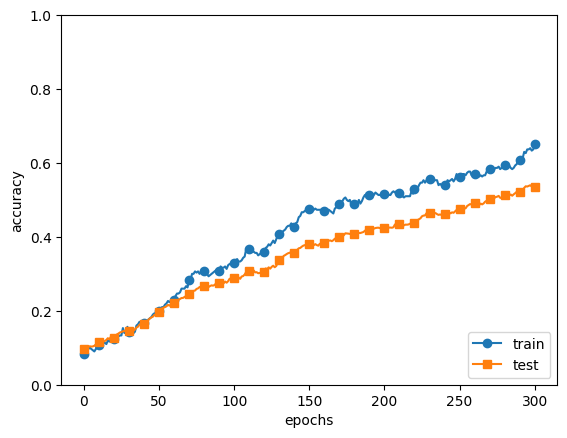

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# 하이퍼파라미터 최적화

In [ ]:
def shuffle_dataset(x, t):
    """데이터셋을 뒤섞는다.

    Parameters
    ----------
    x : 훈련 데이터
    t : 정답 레이블

    Returns
    -------
    x, t : 뒤섞은 훈련 데이터와 정답 레이블
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

val acc:0.07 | lr:4.276141649661204e-06, weight decay:1.3143972075411393e-06
val acc:0.14 | lr:1.5649650193477958e-05, weight decay:9.175634146077365e-08
val acc:0.08 | lr:4.1224897935265195e-05, weight decay:1.5895715222771822e-06
val acc:0.1 | lr:2.952099805743337e-06, weight decay:1.1035335966724071e-05
val acc:0.13 | lr:0.0005867500602687406, weight decay:8.189945622547481e-05
val acc:0.15 | lr:4.0482280386394695e-05, weight decay:3.8162480135144925e-05
val acc:0.08 | lr:7.639764170786197e-06, weight decay:6.399527711307336e-05
val acc:0.16 | lr:0.00011158377899227987, weight decay:3.825765944447406e-07
val acc:0.15 | lr:0.0017303295274593543, weight decay:3.486760175632619e-07
val acc:0.22 | lr:0.0014215265450431198, weight decay:1.6580078162600522e-07
val acc:0.18 | lr:0.0011882327900217355, weight decay:2.85426648169253e-08
val acc:0.21 | lr:0.000586295889449508, weight decay:5.6162487388311854e-05
val acc:0.1 | lr:0.0013140071845474874, weight decay:2.3211516531824025e-05
val a

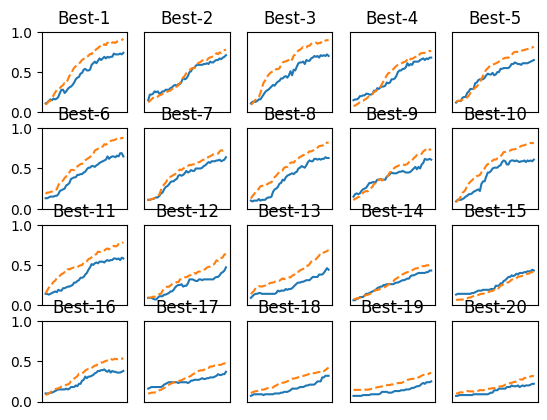

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()